In [1]:
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy import stats
import statsmodels.api as sm
from itertools import product

import pandas as pd
pd.options.display.max_columns = 999
import numpy as np

from sklearn.metrics import mean_squared_error
#RMSE = mean_squared_error(y, y_pred)**0.5

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

## Подготовка данных

In [3]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')

In [4]:
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price['Year']= df_price['Date'].dt.year
df_price['Month'] = df_price['Date'].dt.month
df_price['year_month'] = df_price['Year'].astype(str) + '_' +\
                         df_price['Month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)

In [5]:
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)
df_price['Name_ID'] = df_price['player_name'] + "_" +  df_price['player_id'].astype(str)

In [6]:
df_merge=pd.merge(df_price,df_stats,on='player_id', how='inner')
#df_merge_revision_normal=df_merge[df_merge.revision=='Normal']

In [8]:
#df_merge_revision_normal.groupby(['Name_ID','year_month'])['price'].max().reset_index()
df_merge_revision_normal.groupby(['name','year_month',])['price'].mean().sort_values(ascending=False)

name               year_month
Cristiano Ronaldo  2017_01       1.709007e+06
                   2016_12       1.569421e+06
                   2017_02       1.513418e+06
                   2016_09       1.502000e+06
                   2017_03       1.470011e+06
                   2016_10       1.435849e+06
                   2016_11       1.387468e+06
                   2017_04       1.158901e+06
Messi              2016_09       1.148048e+06
                   2016_10       8.892648e+05
                   2017_01       7.988225e+05
                   2016_12       7.818563e+05
Cristiano Ronaldo  2017_06       7.740405e+05
                   2017_05       7.708267e+05
Messi              2016_11       7.459091e+05
                   2017_02       6.788329e+05
                   2017_03       6.760159e+05
Suárez             2016_09       6.428911e+05
                   2016_10       5.655601e+05
Messi              2017_04       5.438579e+05
Ibrahimovic        2017_01       5.433125e+05
Neym

In [22]:
df_Messi=df_merge[df_merge.player_id==222]#name=='Messi']
df_Messi.shape

(270, 85)

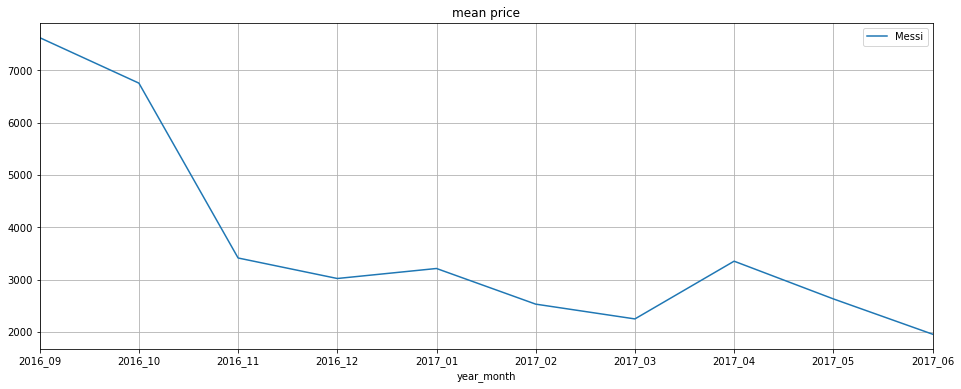

In [23]:
plt.figure(figsize=(16,6))
#df_merge_revision_normal.groupby('year_month')['price'].max().plot(label='all football players')
df_Messi.groupby('year_month')['price'].mean().plot(label='Messi')
plt.title('mean price')
plt.legend()
plt.grid()

In [24]:
df=df_Messi[['Date','price']]
df.shape

(270, 2)

In [25]:
df = df.groupby('Date')[['price']].mean()
df.head()

,price
Date,
2016-09-23,9550
2016-09-24,8825
2016-09-25,8650
2016-09-26,8757
2016-09-27,8817


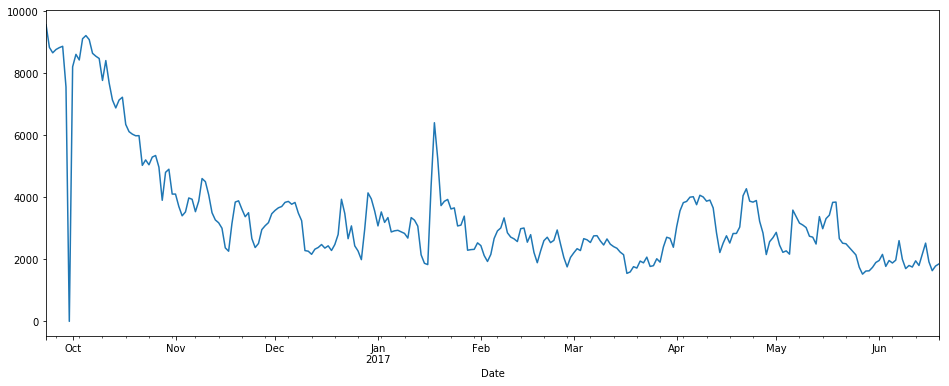

In [26]:
#plotly_df(df.resample('W').apply(sum), title = 'mean price Messi per week')
plt.figure(figsize=(16,6))
df['price'].plot()

# Прогноз
* ## Prophet

In [13]:
#df=df_merge_revision_normal[['Date','price']]
#df = df.groupby('Date')[['price']].mean()

In [40]:
predictions = 7

df = df.reset_index()
df.columns = ['ds', 'y']
df.tail()

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [28]:
train_df = df[:-predictions] 

In [41]:
train_df.head()

,ds,y
0,2016-09-23,9550
1,2016-09-24,8825
2,2016-09-25,8650
3,2016-09-26,8757
4,2016-09-27,8817


In [29]:
m = Prophet()
m.fit(train_df)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [30]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
265,2017-06-15
266,2017-06-16
267,2017-06-17
268,2017-06-18
269,2017-06-19


In [31]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,seasonal,yhat
265,2017-06-15,1.011450,2468.103642,64.426585,64.426585,2467.695696,2468.981380,1298.802522,3835.692792,64.426585,64.426585,64.426585,64.426585,2532.530227
266,2017-06-16,1.015267,2465.503484,-261.763296,-261.763296,2464.144959,2467.614313,1007.897788,3483.342816,-261.763296,-261.763296,-261.763296,-261.763296,2203.740188
267,2017-06-17,1.019084,2462.903327,-55.959536,-55.959536,2460.072288,2467.321790,1179.491225,3645.063136,-55.959536,-55.959536,-55.959536,-55.959536,2406.943791
268,2017-06-18,1.022901,2460.303170,-7.433363,-7.433363,2455.242951,2467.227249,1273.010147,3710.055767,-7.433363,-7.433363,-7.433363,-7.433363,2452.869807
269,2017-06-19,1.026718,2457.703012,-73.810683,-73.810683,2450.323967,2467.399563,1257.799816,3576.534112,-73.810683,-73.810683,-73.810683,-73.810683,2383.892329


In [32]:
print(', '.join(forecast.columns))

ds, t, trend, seasonal_lower, seasonal_upper, trend_lower, trend_upper, yhat_lower, yhat_upper, weekly, weekly_lower, weekly_upper, seasonal, yhat


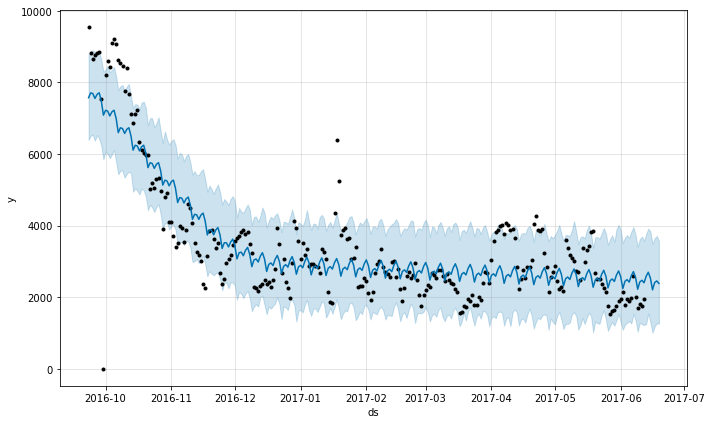

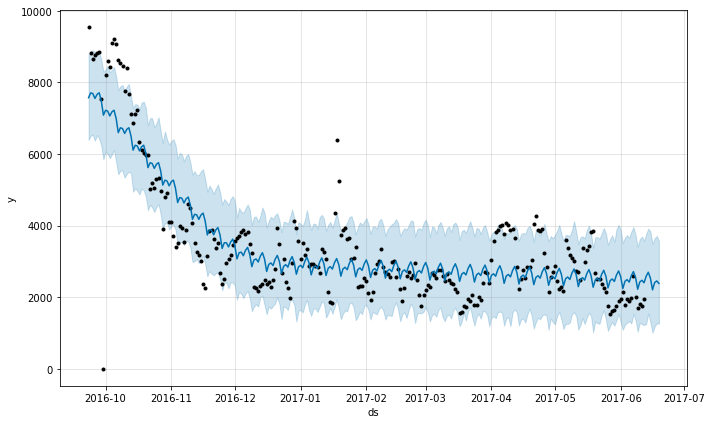

In [33]:
m.plot(forecast)

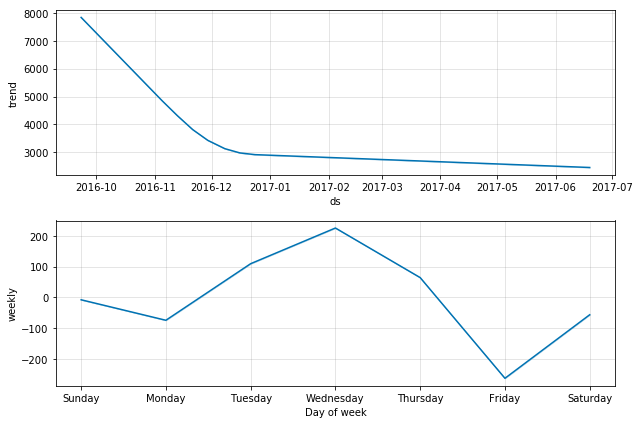

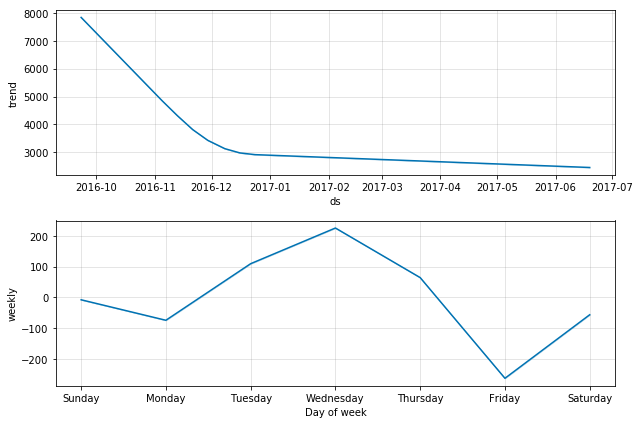

In [34]:
m.plot_components(forecast)

In [35]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [36]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 28.198572099367595
MAE 513.2177700926288


In [39]:
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2017-06-15,2532.530227,1298.802522,3835.692792,2520,-12.530227,-0.497231
2017-06-16,2203.740188,1007.897788,3483.342816,1920,-283.740188,-14.778135
2017-06-17,2406.943791,1179.491225,3645.063136,1633,-773.943791,-47.393986
2017-06-18,2452.869807,1273.010147,3710.055767,1783,-669.869807,-37.569815
2017-06-19,2383.892329,1257.799816,3576.534112,1850,-533.892329,-28.859045


In [37]:
def show_forecast(cmp_df, num_predictions, num_values):

    forecast = go.Scatter(
        name='Prophet',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )


    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )


    data = [forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='price'),
        title='price Messi',
        showlegend = True)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, predictions, 200)

In [42]:
cmp_df.tail(10)

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2017-06-10,2425.144892,1287.173592,3618.784763,1800,-625.144892,-34.730272
2017-06-11,2471.070908,1242.649842,3693.116851,1750,-721.070908,-41.204052
2017-06-12,2402.093431,1220.404472,3573.441931,1950,-452.093431,-23.184278
2017-06-13,2582.773354,1249.297692,3760.969624,1800,-782.773354,-43.487409
2017-06-14,2695.774694,1545.991281,3918.386378,2160,-535.774694,-24.804384
2017-06-15,2532.530227,1298.802522,3835.692792,2520,-12.530227,-0.497231
2017-06-16,2203.740188,1007.897788,3483.342816,1920,-283.740188,-14.778135
2017-06-17,2406.943791,1179.491225,3645.063136,1633,-773.943791,-47.393986
2017-06-18,2452.869807,1273.010147,3710.055767,1783,-669.869807,-37.569815


* ## ARIMA

In [211]:
player1_id = (df_merge.player_id ==  1)
player1_ts = df_merge[player1_id].price
player1_ts.index = df_merge[player1_id].Date
player1_ts.head()

Date
2016-09-23           0
2016-09-24    10000000
2016-09-25           0
2016-09-26           0
2016-09-27    10000000
Name: price, dtype: int64

In [212]:
print(len(player1_ts), len(player1_ts[player1_ts==0]))
player1_ts = player1_ts.replace(to_replace=0, method='bfill')
print(len(player1_ts), len(player1_ts[player1_ts==0]))

270 4
270 0


In [134]:
#train_df = df.fillna(df.y.mean()).set_index('ds')
#train_df = df.set_index('ds')

#df=df_Messi[['Date','price']]

#df = df.groupby('Date')[['price']].mean()
df=df.set_index('ds')
df.head()

,y
ds,
2016-09-23,1477500
2016-09-24,1204419
2016-09-25,1233438
2016-09-26,1126719
2016-09-27,1146559


In [135]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


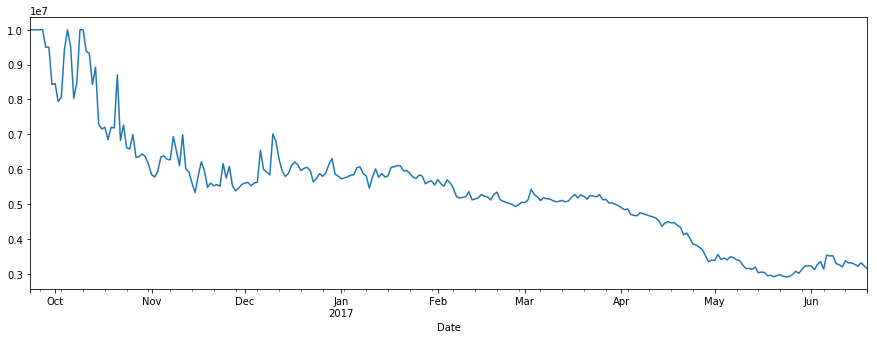

In [213]:
plt.figure(figsize(15,5))
df['y'].plot()

### STL-декомпозиция ряда 

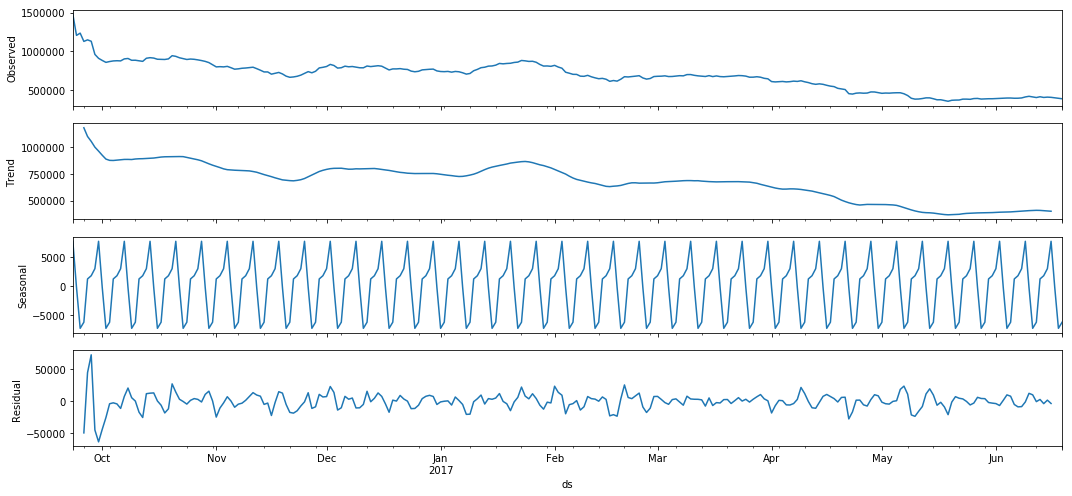

In [137]:
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(df['y']).plot()
pylab.show()

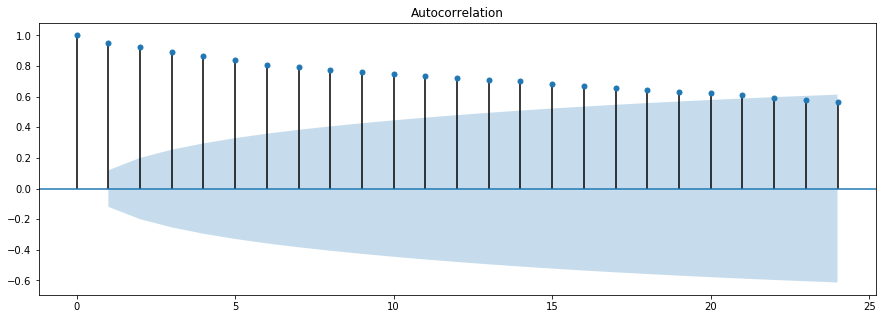

In [140]:
plt.figure(figsize(15,5))
sm.graphics.tsa.plot_acf(df['y'].values, lags=24)
pylab.show()

### Проверка ряда на стационарность

In [141]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])

Критерий Дики-Фуллера: p=0.899885


### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.840593
Критерий Дики-Фуллера: p=0.909746


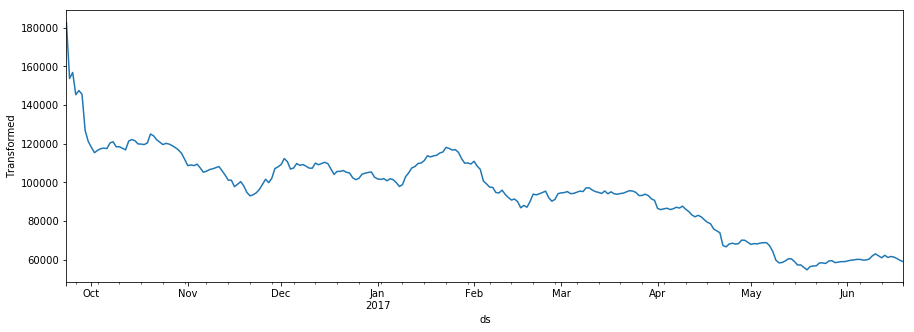

In [142]:
df['y_box'], lmbda = stats.boxcox(df.y)

plt.figure(figsize(15,5))
df.y_box.plot()

plt.ylabel(u'Transformed')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_box)[1])

### Избавляемся от тренда и сезонности

Критерий Дики-Фуллера: p=0.000000


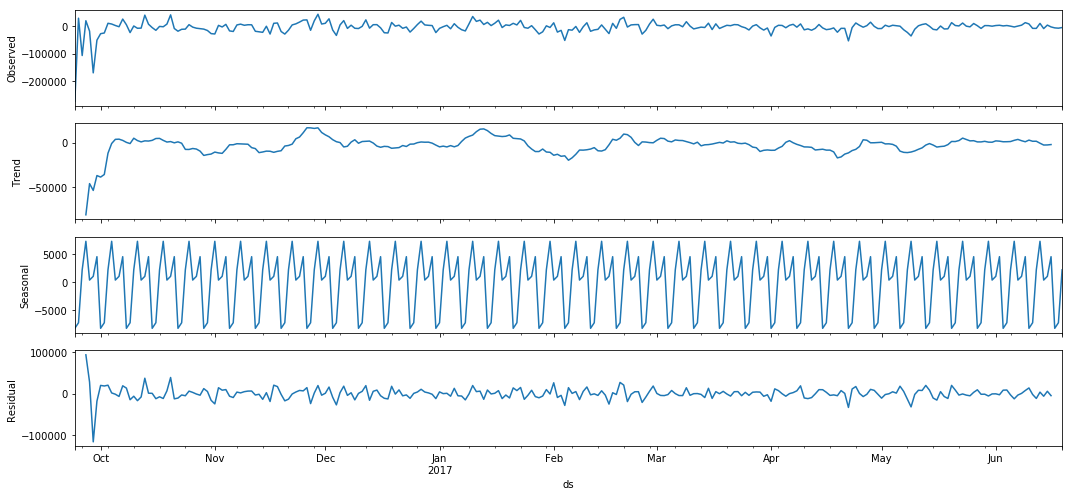

In [169]:
df['y_diff'] = df.y - df.y.shift(1)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(df.y_diff[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_diff[1:])[1])

Критерий Дики-Фуллера: p=0.000000


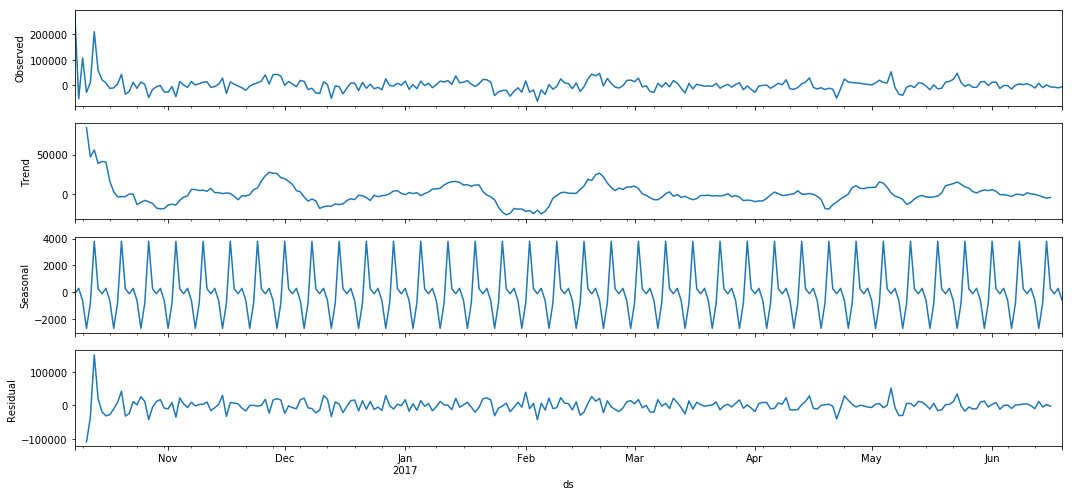

In [148]:
df['y_diff2'] = df.y_diff - df.y_diff.shift(1)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(df.y_diff2[15:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_diff2[15:])[1])

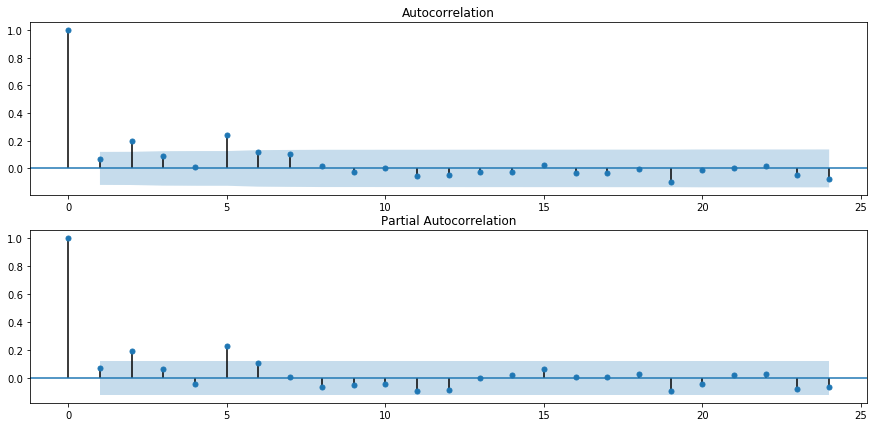

In [171]:
plt.figure(figsize(15,7))
#ACF 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.y_diff[1:].values.squeeze(), lags=24, ax=ax)
#PACF
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.y_diff[1:].values.squeeze(), lags=24, ax=ax)
pylab.show()

In [172]:
ps = range(0, 14)
d=1
qs = range(0, 14)
Ps = range(0, 1)
D=0
Qs = range(0, 1)

In [173]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Количество параметров: {}".format(len(parameters_list)))

Количество параметров: 196


### подбор параметров

In [174]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['y'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 9, 0, 0)
wrong parameters: (2, 10, 0, 0)
wrong parameters: (2, 11, 0, 0)
wrong parameters: (2, 12, 0, 0)
wrong parameters: (2, 13, 0, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 9, 0, 0)
wrong parameters: (3, 10, 0, 0)
wrong parameters: (3, 11, 0, 0)
wrong parameters: (3, 12, 0, 0)
wrong parameters: (3, 13, 0, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 9, 0, 0)
wrong parameters: (4, 10, 0, 0)
wrong parameters: (4, 11, 0, 0)
wrong parameters: (4, 12, 0, 0)
wrong parameters: (4, 13, 0, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 5, 0, 0)
wrong parameters: (5, 7, 0, 0)
wrong parameters: (5, 8, 0, 0)
wrong parameters: (5, 9, 0, 0)
wrong parameters: (5, 10, 0, 0)
wrong parameters: (5, 11, 0, 0)
wrong parameters: (5, 12,

In [175]:
best_param

(3, 6, 0, 0)

In [176]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
39   (3, 6, 0, 0)  5985.598419
59   (7, 6, 0, 0)  5992.509661
85  (12, 9, 0, 0)  5998.617970
65   (8, 7, 0, 0)  5998.760740
70   (9, 3, 0, 0)  6004.799200


In [177]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  270
Model:               SARIMAX(3, 1, 6)   Log Likelihood               -2982.799
Date:                Sat, 01 Jul 2017   AIC                           5985.598
Time:                        09:47:50   BIC                           6021.583
Sample:                    09-23-2016   HQIC                          6000.048
                         - 06-19-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1850      0.068      2.719      0.007       0.052       0.318
ar.L2          0.0763      0.096      0.798      0.425      -0.111       0.264
ar.L3          0.0187      0.079      0.237      0.8

## остатки

Критерий Стьюдента: p=0.000099
Критерий Дики-Фуллера: p=0.000291


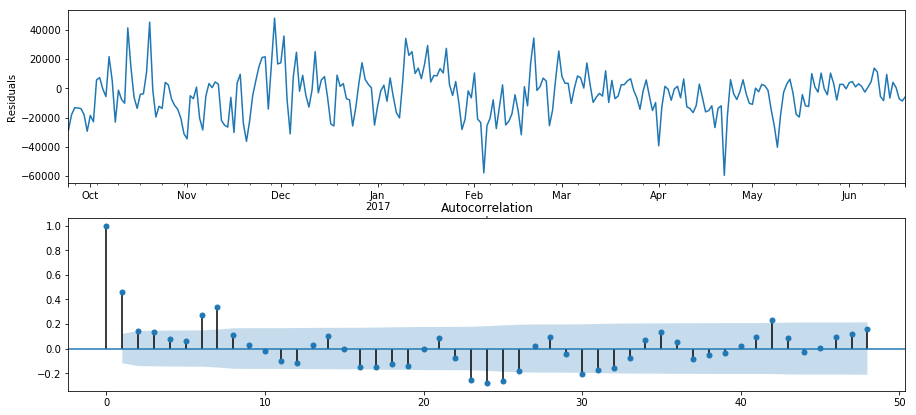

In [182]:
plt.figure(figsize(15,7))
plt.subplot(211)

best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

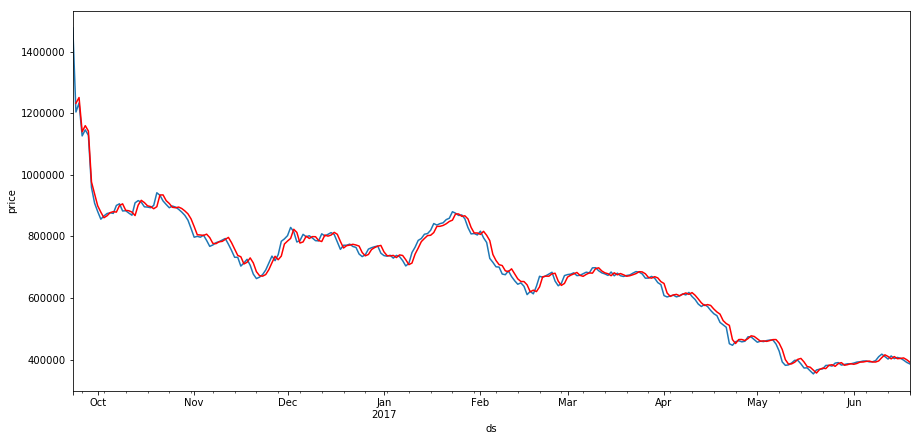

In [185]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

#data['model'] = invboxcox(best_model.fittedvalues, lmbda)
df['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
df.y.plot()
df.model[1:].plot(color='r')
plt.ylabel('price')
pylab.show()

In [186]:
df.iloc[-1]

y          385732.000000
y_box       59046.737850
y_diff      -4962.000000
y_diff2     -5073.000000
model      391380.442242
Name: 2017-06-19 00:00:00, dtype: float64

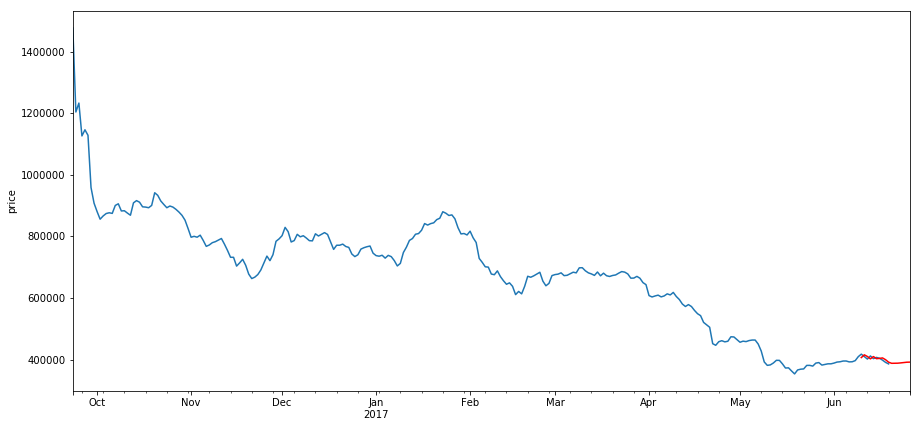

In [195]:
#Строим прогноз на 7 дней вперед
df2 = df[['y']]
date_list = [datetime.datetime.strptime("2017-06-20", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,7)]
future = pd.DataFrame(index=date_list, columns = df.columns)
df2 = pd.concat([df2, future])

df2['forecast'] = best_model.predict(start=260, end=279)

plt.figure(figsize(15,7))
df2.y.plot()
df2.forecast.plot(color='r')
plt.ylabel('price')
pylab.show()

In [196]:
df2.tail(10)

,model,y,y_box,y_diff,y_diff2,forecast
2017-06-17,NaN,397944,NaN,NaN,NaN,405139.351023
2017-06-18,NaN,390694,NaN,NaN,NaN,399401.992589
2017-06-19,NaN,385732,NaN,NaN,NaN,391380.442242
2017-06-20,NaN,NaN,NaN,NaN,NaN,387687.383565
2017-06-21,NaN,NaN,NaN,NaN,NaN,387725.887811
2017-06-22,NaN,NaN,NaN,NaN,NaN,388088.079990
2017-06-23,NaN,NaN,NaN,NaN,NaN,389007.128517
2017-06-24,NaN,NaN,NaN,NaN,NaN,390296.069853
2017-06-25,NaN,NaN,NaN,NaN,NaN,391233.624278
2017-06-26,NaN,NaN,NaN,NaN,NaN,391522.577757


In [189]:
y=[df2.y[-10],df2.y[-9]]
y_pred=[df2.forecast[-10],df2.forecast[-9]]
print(y)
print(y_pred)

[397944, 390694]
[405139.35102334077, 399401.99258937227]


In [190]:
mean_squared_error(y, y_pred)**0.5

7987.5594296898171